# Preliminary experiment - distilled dataset for in-hospital mortality prediction task

## 📖 Libraries

✅ Dependencies.

For cuda, define `device` that'll be used throughout the notebook.

In [2]:
import torch
from torch.utils.data import DataLoader
import importlib
import numpy as np
import torch.nn as nn
import time
from tqdm.notebook import tqdm
import copy
import os
import pickle
from glob import glob

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

Device: cuda


✅ Custom libs. **Always re-run the following code block after modifying `utils`**.

In [3]:
from utils import preprocess, dataset, network, train, report
importlib.reload(preprocess)
importlib.reload(dataset)
importlib.reload(network)
importlib.reload(train)
importlib.reload(report)

<module 'utils.report' from '/project/ruishanl_1185/EHR-Distillation/utils/report.py'>

## 📊 Data preparation

✅ Compute statistics that'll be used for imputation and dataloading.

Statistics can be load from saved pickle.

In [4]:
LOAD_FROM_SAVED = True
STAT_PKL_DIR = "./saved_data/stats/"
if not os.path.exists(STAT_PKL_DIR):
    os.makedirs(STAT_PKL_DIR)

categorical_numcls = {  # how many classes are there for categorical classes
    "capillary_refill_rate": 2,
    "glascow_coma_scale_eye_opening": 4,
    "glascow_coma_scale_motor_response": 6,
    "glascow_coma_scale_total": 13,
    "glascow_coma_scale_verbal_response": 5,
}

pkl_path = os.path.join(STAT_PKL_DIR, "ihm_preliminary.pkl")
if os.path.exists(pkl_path) and LOAD_FROM_SAVED:
    with open(pkl_path, 'rb') as f:
        continuous_avgs_train, continuous_stds_train, categorical_modes_train = pickle.load(f)
else:
    continuous_avgs_train, continuous_stds_train, categorical_modes_train =  preprocess.compute_feature_statistics(
        ts_dir="./data/mimic3/benchmark/in-hospital-mortality/train/",
        feature_dict=preprocess.mimic3_benchmark_variable_dict
        )
    with open(pkl_path, 'wb') as f:
        pickle.dump((continuous_avgs_train, continuous_stds_train, categorical_modes_train), f)

Clean all data by resampling, imputating and masking.

**Running this block once is enough.**
(Cleaned data will be saved at ./data/mimic3/ihm_preliminary/)

In [ ]:
preprocess.preprocess_ihm_timeseries_files(
    ts_dir="./data/mimic3/benchmark/in-hospital-mortality/train/",
    output_dir="./data/mimic3/ihm_preliminary/train/",
    feature_dict=preprocess.mimic3_benchmark_variable_dict,
    normal_value_dict=continuous_avgs_train|categorical_modes_train
    )
preprocess.preprocess_ihm_timeseries_files(
    ts_dir="./data/mimic3/benchmark/in-hospital-mortality/test/",
    output_dir="./data/mimic3/ihm_preliminary/test/",
    feature_dict=preprocess.mimic3_benchmark_variable_dict,
    normal_value_dict=continuous_avgs_train|categorical_modes_train
    )

✅ Define original mimic3 benchmark training and evaluation datasets for IHM objective.

Apply mask / balance to the dataset here.

You may have to re-run this block after modifying dataloader-related codes.

In [5]:
# Pay attention to balance and mask settings

BALANCE = False
MASK = False

train_set = dataset.IHMPreliminaryDatasetReal(
    dir="./data/mimic3/ihm_preliminary/train/",
    dstype="train",
    avg_dict=continuous_avgs_train,
    std_dict=continuous_stds_train,
    numcls_dict=categorical_numcls,
    balance=BALANCE,
    mask=MASK,
    )
print(f"First item in the dataset: \n{train_set[0]}")
print(f"Feature tensor shape: {train_set[0][0].shape}")

test_set = dataset.IHMPreliminaryDatasetReal(
    dir="./data/mimic3/ihm_preliminary/test/",
    dstype="test",
    avg_dict=continuous_avgs_train,
    std_dict=continuous_stds_train,
    numcls_dict=categorical_numcls,
    balance=BALANCE,
    mask=MASK,
    )
print(f"First item in the dataset: \n{test_set[0]}")
print(f"Feature tensor shape: {test_set[0][0].shape}")

input_shape = train_set[0][0].shape
print(f"Input tensor shape: {input_shape}")

First item in the dataset: 
(tensor([[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0668,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000,  0.0489,  ...,  0.0220,  0.0000,  0.0000],
        ...,
        [ 1.0000,  0.0000,  0.0980,  ..., -0.0870,  4.1913,  0.0000],
        [ 1.0000,  0.0000,  0.1293,  ..., -0.0870,  4.1913,  0.0000],
        [ 1.0000,  0.0000,  0.0176,  ..., -0.0870,  4.1913,  0.0000]]), tensor(0))
Feature tensor shape: torch.Size([48, 42])
First item in the dataset: 
(tensor([[ 1.0000,  0.0000,  0.0310,  ..., -0.1730, -0.8523,  0.0391],
        [ 1.0000,  0.0000,  0.0578,  ..., -0.1615, -0.8523,  0.0391],
        [ 1.0000,  0.0000,  0.0623,  ..., -0.1615, -0.8523,  0.0391],
        ...,
        [ 1.0000,  0.0000,  0.0132,  ...,  0.0335, -0.5163,  0.0521],
        [ 1.0000,  0.0000,  0.0087,  ...,  0.0335, -0.5163,  0.0521],
        [ 1.0000,  0.0000,  0.0400,  ...,  0.0335, -0.5163,  0.0521]]), tensor(0))
Feature

See the label distribution in the datasets.

In [8]:
label_0_cnt = 0
label_1_cnt = 1
for _, label in test_set:
    if label > 0.5:
        label_1_cnt += 1
    else:
        label_0_cnt += 1
print(f"Total datapoints: {label_0_cnt + label_1_cnt}")
print(f"Label 0 ratio: {label_0_cnt / (label_0_cnt + label_1_cnt)}")
print(f"Label 1 ratio: {label_1_cnt / (label_0_cnt + label_1_cnt)}")

Total datapoints: 17904
Label 0 ratio: 0.8646112600536193
Label 1 ratio: 0.1353887399463807


## 💭 Evaluating model capacity on training objectives

Train an 1D CNN and save the best performing weights.

In [ ]:
# define hyper params
ihm_epoch = 100
ihm_batch_size = 256
ihm_lr = 1e-3
ihm_wd = 1e-3

# train 1D CNN

SYN_DATA_SAVE_DIR = "./saved_data/ihm_model/"
if not os.path.exists(SYN_DATA_SAVE_DIR):
    os.makedirs(SYN_DATA_SAVE_DIR)

NUM_WORKERS = 8

train_loader = DataLoader(train_set, ihm_batch_size, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set, ihm_batch_size, num_workers=NUM_WORKERS)

model = network.IHMPreliminary1DCNN(input_shape=input_shape).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=ihm_lr, weight_decay=ihm_wd)
criterion = nn.CrossEntropyLoss()


pbar = tqdm(range(ihm_epoch), desc="Training on original task")
min_loss = float("inf")
for e in pbar:
    train_loss, train_acc = train.epoch("train", train_loader, model, criterion, optimizer, device=DEVICE)
    test_loss, test_acc = train.epoch("test", test_loader, model, criterion, device=DEVICE)
    if train_loss < min_loss:
        filename = f'ihm_1dcnn_e{e}_trl{train_loss:.4f}_tel{test_loss:.4f}.pt'
        file_path = os.path.join(SYN_DATA_SAVE_DIR, filename)

        # Remove the previous checkpoint if it exists
        existing_pts = [f for f in os.listdir(SYN_DATA_SAVE_DIR) if f.startswith(f'ihm_1dcnn_e{e}_') and f.endswith('.pt')]
        for f in existing_pts:
            os.remove(os.path.join(SYN_DATA_SAVE_DIR, f))
        torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss,
            }, file_path)
    
    pbar.set_description(f"Training on original task, epoch {e}\ntrain loss = {train_loss}, train acc = {train_acc}\ntest loss = {test_loss}, test acc = {test_acc}")

Train an MLP and save the best performing weights.

In [ ]:
# define hyper params
ihm_epoch = 100
ihm_batch_size = 256
ihm_lr = 1e-3
ihm_wd = 1e-3

# train MLP

SYN_DATA_SAVE_DIR = "./saved_data/ihm_model/"
if not os.path.exists(SYN_DATA_SAVE_DIR):
    os.makedirs(SYN_DATA_SAVE_DIR)

NUM_WORKERS = 8

train_loader = DataLoader(train_set, ihm_batch_size, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set, ihm_batch_size, num_workers=NUM_WORKERS)

model = network.IHMPreliminaryMLP(input_shape=input_shape).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=ihm_lr, weight_decay=ihm_wd)
criterion = nn.CrossEntropyLoss()


pbar = tqdm(range(ihm_epoch), desc="Training on original task")
min_loss = float("inf")
for e in pbar:
    train_loss, train_acc = train.epoch("train", train_loader, model, criterion, optimizer, device=DEVICE)
    test_loss, test_acc = train.epoch("test", test_loader, model, criterion, device=DEVICE)
    if train_loss < min_loss:
        filename = f'ihm_mlp_e{e}_trl{train_loss:.4f}_tel{test_loss:.4f}.pt'
        file_path = os.path.join(SYN_DATA_SAVE_DIR, filename)

        # Remove the previous checkpoint if it exists
        existing_pts = [f for f in os.listdir(SYN_DATA_SAVE_DIR) if f.startswith(f'ihm_mlp_e{e}_') and f.endswith('.pt')]
        for f in existing_pts:
            os.remove(os.path.join(SYN_DATA_SAVE_DIR, f))
        torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss,
            }, file_path)
    
    pbar.set_description(f"Training on original task, epoch {e}\ntrain loss = {train_loss}, train acc = {train_acc}\ntest loss = {test_loss}, test acc = {test_acc}")

Baselines: train the model with randomly sampled subset of datapoints

In [23]:
# choose model
MODEL = ["1dcnn", "mlp"][1]

# define hyper params
EPOCH = 100
BATCH_SIZE = 256
LR = 1e-3
WD = 1e-3

SYN_DATA_SAVE_DIR = "./saved_data/ihm_model/"
if not os.path.exists(SYN_DATA_SAVE_DIR):
    os.makedirs(SYN_DATA_SAVE_DIR)

# define num sampled datapoints
N_SAMPLES_PER_CLS = 10

# Sample from class 0
ts_class_0, lab_class_0 = train_set.random_sample_from_class(n_samples=N_SAMPLES_PER_CLS, cls=0, no_duplicate=True)
# Sample from class 1
ts_class_1, lab_class_1 = train_set.random_sample_from_class(n_samples=N_SAMPLES_PER_CLS, cls=1, no_duplicate=True)
# Concatenate the time series data along the first dimension (batch size)
ts_real = torch.cat((ts_class_0, ts_class_1), dim=0).to(DEVICE)
# Concatenate the labels along the 0th dimension
lab_real = torch.cat((lab_class_0, lab_class_1), dim=0).to(DEVICE)
# print(ts_real.shape, lab_real.shape) # batch_size * num_time_steps * num_features

sample_set = dataset.TensorDataset(ts_real, lab_real)
print(f"Sample set size = {len(sample_set)}")

# define dataloaders
NUM_WORKERS = 8
sample_loader = DataLoader(sample_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

if MODEL == "1dcnn":
    model = network.IHMPreliminary1DCNN(input_shape=input_shape).to(DEVICE)
else:
    model = network.IHMPreliminaryMLP(input_shape=input_shape).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
loss_fn = nn.CrossEntropyLoss()


pbar = tqdm(range(EPOCH), desc=f"Training on sampled dataset (size={2*N_SAMPLES_PER_CLS})")
min_loss = float("inf")
for e in pbar:
    train_loss, train_acc = train.epoch("train", sample_loader, model, loss_fn, optimizer, device=DEVICE) # attention: using sampled dataset
    test_loss, test_acc = train.epoch("test", test_loader, model, loss_fn, device=DEVICE)
    if train_loss < min_loss:
        filename = f'ihm_{MODEL}_spc{N_SAMPLES_PER_CLS}_e{e}_trl{train_loss:.4f}_tel{test_loss:.4f}.pt'
        file_path = os.path.join(SYN_DATA_SAVE_DIR, filename)

        # Remove the previous checkpoint if it exists
        existing_pts = [f for f in os.listdir(SYN_DATA_SAVE_DIR) if f.startswith(f'ihm_{MODEL}_spc{N_SAMPLES_PER_CLS}_e{e}_') and f.endswith('.pt')]
        for f in existing_pts:
            os.remove(os.path.join(SYN_DATA_SAVE_DIR, f))
        torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss,
            }, file_path)
    
    pbar.set_postfix({"train loss": f"{train_loss:.4f}",
                      "train acc": f"{train_acc*100:.2f}%",
                      "test loss": f"{test_loss:.4f}",
                      "test acc": f"{test_acc*100:.2f}%",
                      })

Sample set size = 20


Training on sampled dataset (size=20):   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

Load a saved model and evaluate on evaluation set.

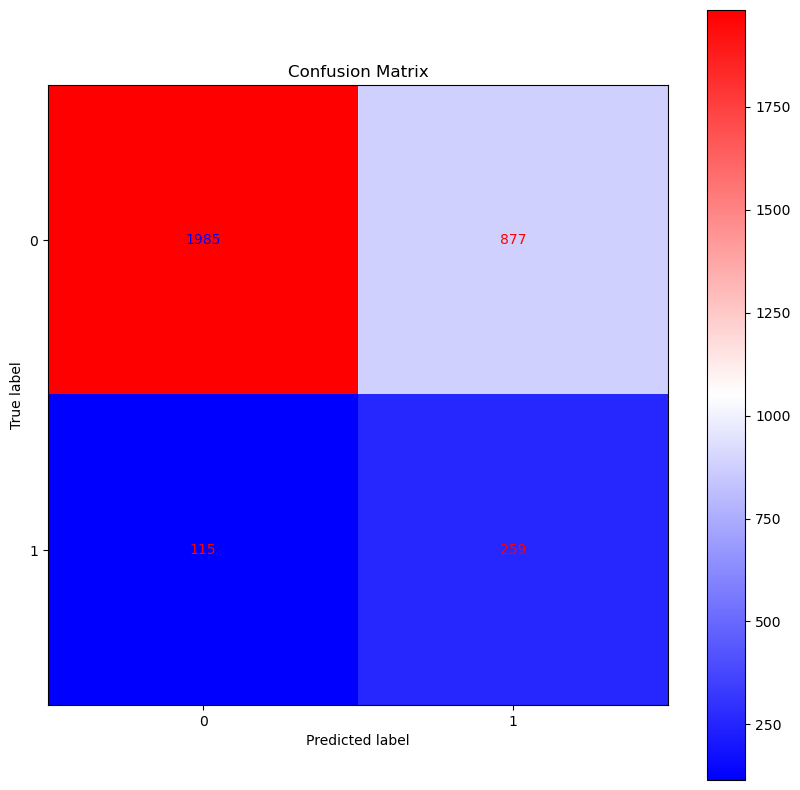

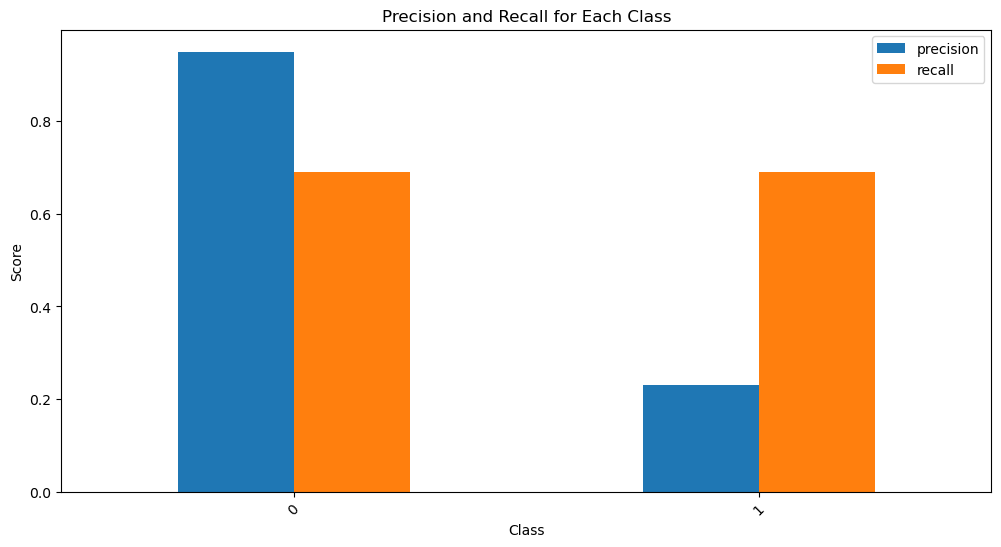

Macro AUC-ROC score: 0.7470094956221482


(array([[1985,  877],
        [ 115,  259]]),
 {'0': {'precision': 0.9452380952380952,
   'recall': 0.693570929419986,
   'f1-score': 0.800080612656187,
   'support': 2862},
  '1': {'precision': 0.22799295774647887,
   'recall': 0.6925133689839572,
   'f1-score': 0.343046357615894,
   'support': 374},
  'accuracy': 0.6934487021013597,
  'macro avg': {'precision': 0.586615526492287,
   'recall': 0.6930421492019716,
   'f1-score': 0.5715634851360405,
   'support': 3236},
  'weighted avg': {'precision': 0.8623426436244165,
   'recall': 0.6934487021013597,
   'f1-score': 0.7472589774939282,
   'support': 3236}},
 0.7470094956221482)

In [27]:
# Evaluate saved model
SYN_DATA_SAVE_DIR = "./saved_data/ihm_model/"
PT_NAME_GLOB = "ihm_mlp_spc10_e0_*.pt"
eval_model = network.IHMPreliminaryMLP(input_shape=(48, 42))

model_pt = glob(os.path.join(SYN_DATA_SAVE_DIR, PT_NAME_GLOB))[0]
model_data = torch.load(model_pt, map_location=torch.device(DEVICE))

eval_model.load_state_dict(model_data["model_state_dict"])
eval_model.to(DEVICE)
eval_model.eval()

# load eval set
NUM_WORKERS = 8
BATCH_SIZE = 256
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS) # pay attention to the test set used here

report.run_classificatoin_report(eval_model, test_loader)

## 🧪 EHR Distillation

### 🌿 Vanilla dataset distillation

In [ ]:
# Vanilla Dataset Distillation intends to get dataset that is able to train a model within only 1 epoch

# define hyper params
NUM_OPTIM_IT = 1000
EVAL_EVERY_NUM_IT = 10

INIT_LR = 0.001
STEP_SIZE = 0.001
INIT_WEIGHTS_DISTR = "kaiming"
BATCH_SIZE = 256
NUM_SAMPLED_MODELS_TRAIN = 16
NUM_SAMPLED_MODELS_EVAL = 4
N_SAMPLES_PER_CLS = 10

# checkpoints saving
CHCKPNT_SAVE_DIR = "./saved_data"
if not os.path.exists(CHCKPNT_SAVE_DIR):
    os.makedirs(CHCKPNT_SAVE_DIR)

# prepare dataloaders
NUM_WORKERS = 8
train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set, BATCH_SIZE, num_workers=NUM_WORKERS)

# initialize random synth dataset
ts_syn = torch.randn(size=(2*N_SAMPLES_PER_CLS, input_shape[0], input_shape[1]), dtype=torch.float, requires_grad=True, device=DEVICE) # device is ignored by far
lab_syn = torch.tensor(np.array([np.ones(N_SAMPLES_PER_CLS)*i for i in (0, 1)]), dtype=torch.long, requires_grad=False, device=DEVICE).view(-1) # 1-D, length = episodes_per_cls * 2

# initialize learning rate
lr = torch.tensor([INIT_LR], dtype=torch.float, requires_grad=True, device=DEVICE) # make it learnable

optimizer_ts = torch.optim.Adam([ts_syn], lr=STEP_SIZE)
optimizer_lr = torch.optim.Adam([lr], lr=STEP_SIZE)

loss_fn = torch.nn.CrossEntropyLoss()

# data used for plotting curves
optim_losses = [] # optimization objective loss each iteration
min_optim_loss = float('inf')
syn_lrs = [] # synthetic lr
eval_scores_train = [] # evaluation avg roc-auc score on train set
eval_scores_test = [] # evaluation avg roc-auc score on test set

# begin training steps
pbar = tqdm(range(NUM_OPTIM_IT), desc="Distilling dataset using vanilla DD")
for it in pbar:
    # get a minibatch of real training data
    # Sample from class 0
    ts_class_0, lab_class_0 = train_set.random_sample_from_class(n_samples=BATCH_SIZE//2, cls=0)
    # ts_class_0, lab_class_0 = train_set.first_n_samples_from_class(n_samples=BATCH_SIZE//2, cls=0)
    # Sample from class 1
    ts_class_1, lab_class_1 = train_set.random_sample_from_class(n_samples=BATCH_SIZE//2, cls=1)
    # ts_class_1, lab_class_1 = train_set.first_n_samples_from_class(n_samples=BATCH_SIZE//2, cls=1)
    # Concatenate the time series data along the first dimension (batch size)
    ts_real = torch.cat((ts_class_0, ts_class_1), dim=0).to(DEVICE)
    # Concatenate the labels along the 0th dimension
    lab_real = torch.cat((lab_class_0, lab_class_1), dim=0).to(DEVICE)
    # print(ts_real.shape, lab_real.shape) # batch_size * num_time_steps * num_features

    # evaluate the distilled data every `EVAL_EVERY_NUM_IT` iterations
    if it % EVAL_EVERY_NUM_IT == 0:
        print(f"Optimization iteration {it} evaluation begins...")
        ts_syn_chckpnt = ts_syn.detach().clone()
        # lab_syn are not learning objectives so just use it in-place
        lr_chckpnt = lr.detach().clone()
        # sample a batch of models
        sampled_models = []
        local_train_scores = []
        local_test_scores = []
        for j in range(NUM_SAMPLED_MODELS_EVAL):
            torch.random.manual_seed(int(time.time() * 1000) % 100000) # random seed
            # torch.random.manual_seed(42) # fixed seed
            model = network.IHMPreliminary1DCNN(input_shape=input_shape, init_distr=INIT_WEIGHTS_DISTR).to(DEVICE)
            sampled_models.append(model)
        for model in sampled_models:
            model.train()
            optimizer = torch.optim.SGD(model.parameters(), lr=lr_chckpnt.item())
            # train the models on synthetic set
            pred_syn = model(ts_syn_chckpnt)
            loss_syn = loss_fn(pred_syn, lab_syn)
            optimizer.zero_grad()
            loss_syn.backward()
            optimizer.step()
        for model in sampled_models:
            # evaluate the models on both full train set and test set
            train_auc_roc = report.compute_roc_auc_score(model, train_loader)
            test_auc_roc = report.compute_roc_auc_score(model, test_loader)
            local_train_scores.append(train_auc_roc)
            local_test_scores.append(test_auc_roc)
        eval_scores_train.append(sum(local_train_scores) / len(local_train_scores))
        eval_scores_test.append(sum(local_test_scores) / len(local_test_scores))
        print(f"Optimization iteration {it}, eval score (train): {eval_scores_train[-1]:.4f}, eval score (test): {eval_scores_test[-1]:.4f}")
    
    # sample a batch of models
    sampled_models = []
    for j in range(NUM_SAMPLED_MODELS_TRAIN):
        torch.random.manual_seed(int(time.time() * 1000) % 100000) # random seed
        # torch.random.manual_seed(42) # fixed seed
        model = network.IHMPreliminary1DCNN(input_shape=input_shape, init_distr=INIT_WEIGHTS_DISTR).to(DEVICE)
        sampled_models.append(model)
        
    optimizer_ts.zero_grad()
    optimizer_lr.zero_grad()

    losses = []
    for model in sampled_models:
        # Step 1: Train each sampled model on synthetic dataset
        model.train()
        pred_syn = model(ts_syn)
        loss_syn = loss_fn(pred_syn, lab_syn)
        
        for m in model.modules():
            param_names = []
            new_params = []
            for n, p in m.named_parameters(recurse=False): # n is the param's name alone instead of "module.name"
                gp, = torch.autograd.grad(loss_syn, p, create_graph=True) # enabling higher-order derivatives
                new_p = p - lr * gp
                new_p.to(DEVICE)
                param_names.append(n) # save them, to delete leaf params later in another enumeration
                new_params.append(new_p) # save them, to reset non-leaf params later in another enumeration
            for i, n in enumerate(param_names):
                delattr(m, n)
                setattr(m, n, new_params[i])

        # Step 2: Evaluate the objective function on real training data
        pred_real = model(ts_real)
        loss_real = loss_fn(pred_real, lab_real)
        losses.append(loss_real)

        # Clear gradients for the next model
        model.zero_grad()

    # Check if params are swapped as non-leaves
    # for model in sampled_models:
    #     for m in model.modules():
    #         for n, p in m.named_parameters(recurse=False): # name is the param's name alone instead of module.name
    #             print(p.grad_fn)
    
    # Step 3: Update synthetic data and learnable learning rate
    total_loss = sum(losses)
    total_loss.backward()  # Compute gradients based on real data losses

    # Update synthetic data and learning rate
    # print(lr.grad) # shouldn't be none
    # print(ts_syn.grad) # shouldn't be none
    optimizer_ts.step()
    optimizer_lr.step()

    # Logging the progress
    pbar.set_postfix({"loss": f"{total_loss.item():.4f}",
                      "learnable lr": f"{lr.item()}",
                      })
    optim_losses.append(total_loss.item())
    syn_lrs.append(lr.item())

    if total_loss.item() < min_optim_loss or it >= NUM_OPTIM_IT - 1: # save checkpoint
        min_optim_loss = total_loss.item()
        print(f"New best! Saving checkpoint iteration {it}...")
        checkpoint = {
            "it": it,
            "ts_syn": ts_syn.detach().clone(),
            "lab_syn": lab_syn.detach().clone(),
            'optim_losses': optim_losses,
            'syn_lrs': syn_lrs,
            'eval_scores_train': eval_scores_train,
            'eval_scores_test': eval_scores_test,
        }
        # Save checkpoint
        torch.save(checkpoint, os.path.join(CHCKPNT_SAVE_DIR, 'distillation_checkpoint.pth'))
        print(f"Checkpoint at iteration {it} saved")
    

### 🌈 Distill by matching gradients

In [11]:
# Distill with matching loss

MODEL = ["1dcnn", "mlp"][1]

if MODEL == "1dcnn":
    get_model = network.IHMPreliminary1DCNN
else:
    get_model = network.IHMPreliminaryMLP
# define hyper params
TRAIN_IT = 100
EVAL_EVERY_NUM_IT = -1
EVAL_NUM_EPOCHS = 50
NUM_SAMPLED_MODELS_EVAL = 4
LR_DATA = 0.01
LR_NET = 0.01
NUM_OUTER_LOOP = 10
NUM_INNER_LOOP = 50
REAL_BATCH_SIZE = 256
SYN_BATCH_SIZE = 256

N_SAMPLES_PER_CLS = 10
INIT_WEIGHTS_DISTR = None

# prepare dataloaders
NUM_WORKERS = 8
train_loader = DataLoader(train_set, REAL_BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set, REAL_BATCH_SIZE, num_workers=NUM_WORKERS)

# initialize synthetic data
episodes_syn = torch.randn(size=(2*N_SAMPLES_PER_CLS, input_shape[0], input_shape[1]), dtype=torch.float, requires_grad=True, device=DEVICE)
labels_syn = torch.tensor(np.array([np.ones(N_SAMPLES_PER_CLS)*i for i in (0, 1)]), dtype=torch.long, requires_grad=False, device=DEVICE).view(-1) # 1D, length = episodes_per_cls * 2

# define training optimizers and criterion
optimizer_ts = torch.optim.SGD([episodes_syn,], lr=LR_DATA, momentum=0.5) # optimizer for synthetic data
optimizer_ts.zero_grad()
criterion = nn.CrossEntropyLoss()
print("Ready for training")

# data for plotting curves
eval_scores_train = [] # evaluation avg roc-auc score on train set
eval_scores_test = [] # evaluation avg roc-auc score on test set
avg_losses = []
min_avg_loss = float('inf')

SYN_DATA_SAVE_DIR = "./saved_data/dd/"
if not os.path.exists(SYN_DATA_SAVE_DIR):
    os.makedirs(SYN_DATA_SAVE_DIR)
pbar = tqdm(range(TRAIN_IT), desc="Training iteration")
for it in pbar:

    # evaluate the distilled data every `EVAL_EVERY_NUM_IT` iterations
    if EVAL_EVERY_NUM_IT > 0 and it % EVAL_EVERY_NUM_IT == 0:
        print(f"Distillation iteration {it} evaluation begins...")
        episodes_syn_chckpnt = copy.deepcopy(episodes_syn.detach())
        syn_dataset = dataset.TensorDataset(episodes_syn_chckpnt, copy.deepcopy(labels_syn)) # lab_syn are not learning objectives so just use it in-place
        syn_loader = DataLoader(syn_dataset, SYN_BATCH_SIZE, shuffle=True)
        
        # sample a batch of models
        sampled_models = []
        local_train_scores = []
        local_test_scores = []
        for j in range(NUM_SAMPLED_MODELS_EVAL):
            torch.random.manual_seed(int(time.time() * 1000) % 100000) # random seed
            # torch.random.manual_seed(42) # fixed seed
            model = get_model(input_shape=input_shape, init_distr=INIT_WEIGHTS_DISTR).to(DEVICE)
            optimizer = torch.optim.SGD(model.parameters(), lr=LR_NET)
            sampled_models.append(model)
        for model in sampled_models:
            # update network
            for e in range(EVAL_NUM_EPOCHS):
                train.epoch("train", syn_loader, model, criterion, optimizer=optimizer)
        
        print(f"Training {NUM_SAMPLED_MODELS_EVAL} models for evaluation done. Generating classification reports...")
        sub_pbar = tqdm(range(NUM_SAMPLED_MODELS_EVAL), desc="Generating classification reports for each model...",leave=False)
        for idx in sub_pbar:
            model = sampled_models[idx]
            # evaluate the models on both full train set and test set
            train_auc_roc = report.compute_roc_auc_score(model, train_loader)
            test_auc_roc = report.compute_roc_auc_score(model, test_loader)
            local_train_scores.append(train_auc_roc)
            local_test_scores.append(test_auc_roc)
        eval_scores_train.append(sum(local_train_scores) / len(local_train_scores))
        eval_scores_test.append(sum(local_test_scores) / len(local_test_scores))
        print(f"Optimization iteration {it}, eval score (train): {eval_scores_train[-1]:.4f}, eval score (test): {eval_scores_test[-1]:.4f}")
    

    # Train synthetic data
    torch.random.manual_seed(int(time.time() * 1000) % 100000) # random init network
    net = get_model(input_shape=input_shape, init_distr=INIT_WEIGHTS_DISTR).to(DEVICE)
    net.train()
    net_params = list(net.parameters())

    optimizer_net = torch.optim.SGD(net.parameters(), lr=LR_NET)
    optimizer_net.zero_grad()
    loss_avg = 0

    for ol in range(NUM_OUTER_LOOP):
        # update synthetic data
        loss = torch.tensor(0.0).to(DEVICE)
        for cls in (0, 1):
            ts_real, lab_real = train_set.random_sample_from_class(n_samples=REAL_BATCH_SIZE, cls=cls, no_duplicate=True)
            ts_real, lab_real = ts_real.to(DEVICE), lab_real.to(DEVICE)
            ts_syn = episodes_syn[cls*N_SAMPLES_PER_CLS: (cls+1)*N_SAMPLES_PER_CLS]
            lab_syn = labels_syn[cls*N_SAMPLES_PER_CLS: (cls+1)*N_SAMPLES_PER_CLS]

            out_real = net(ts_real)
            loss_real = criterion(out_real, lab_real)
            grad_real = torch.autograd.grad(loss_real, net_params)
            grad_real = [_.detach().clone() for _ in grad_real]

            out_syn = net(ts_syn)
            loss_syn = criterion(out_syn, lab_syn)
            grad_syn = torch.autograd.grad(loss_syn, net_params, create_graph=True) # create_graph: will be used to compute higher-order derivatives

            # compute gradient matching loss, here using MSE, instead of the one proposed in DCwMG because it's too complicated
            # dis = torch.tensor(0.0).to(DEVICE)
            grad_real_vec = []
            grad_syn_vec = []
            for ig in range(len(grad_real)):
                grad_real_vec.append(grad_real[ig].reshape((-1)))
                grad_syn_vec.append(grad_syn[ig].reshape((-1)))
            grad_real_vec = torch.cat(grad_real_vec, dim=0)
            grad_syn_vec = torch.cat(grad_syn_vec, dim=0)
            dis = torch.sum((grad_syn_vec - grad_real_vec)**2)

            loss += dis
        
        optimizer_ts.zero_grad()
        loss.backward()
        optimizer_ts.step()
        loss_avg += loss.item()

        if ol == NUM_OUTER_LOOP - 1:
            break

        # update network
        episodes_syn_train, labels_syn_train = copy.deepcopy(episodes_syn.detach()), copy.deepcopy(labels_syn.detach())  # avoid any unaware modification
        syn_dataset = dataset.TensorDataset(episodes_syn_train, labels_syn_train)
        syn_loader = DataLoader(syn_dataset, SYN_BATCH_SIZE, shuffle=True)
        for il in range(NUM_INNER_LOOP):
            train.epoch("train", syn_loader, net, criterion, optimizer=optimizer_net)

    loss_avg /= (2 * NUM_OUTER_LOOP)
    pbar.set_postfix({"avg loss": f"{loss_avg:.4f}",
                      })
    avg_losses.append(loss_avg)
    if loss_avg < min_avg_loss:
        min_avg_loss = loss_avg

    torch.save({"data": (copy.deepcopy(episodes_syn.detach().cpu()), copy.deepcopy(labels_syn.detach().cpu())),
                "size": (2*N_SAMPLES_PER_CLS, input_shape[0], input_shape[1]),
                },
            os.path.join(SYN_DATA_SAVE_DIR, f"mg_{MODEL}_it{it}_avgl{loss_avg:.4f}.pt")
            )



Ready for training


Training iteration:   0%|          | 0/100 [00:00<?, ?it/s]

## 🤔️ Evaluate distilled dataset

In [ ]:
# Simultaneously train 2 models on distilled dataset and original dataset, compare performance
N_SAMPLES_PER_CLS = 10

REAL_BATCH_SIZE = 256
SYN_BATCH_SIZE = 2*N_SAMPLES_PER_CLS

SYN_DATA_SAVE_DIR = "./saved_data/dd/"
SYN_DATA_GLOB = "md_it47_*.pt"
syn_pt_path = glob(os.path.join(SYN_DATA_SAVE_DIR, SYN_DATA_GLOB))[0]
syn_data = torch.load(syn_pt_path, map_location=torch.device(DEVICE))
syn_ts, syn_lab = syn_data["data"]
syn_ts = syn_ts.to(DEVICE)
syn_lab = syn_lab.to(DEVICE)
syn_set = dataset.TensorDataset(syn_ts, syn_lab)
syn_loader = DataLoader(syn_set, 2*N_SAMPLES_PER_CLS)

NUM_WORKERS = 8
real_set = dataset.IHMPreliminaryDatasetReal(
    dir="./data/mimic3/ihm_preliminary/train/",
    dstype="train",
    avg_dict=continuous_avgs_train,
    std_dict=continuous_stds_train,
    numcls_dict=categorical_numcls,
    balance=False,
    mask=False,
    )
real_loader = DataLoader(real_set, REAL_BATCH_SIZE, num_workers=NUM_WORKERS)

model_syn = network.IHMPreliminary1DCNN().to(DEVICE)
model_real = network.IHMPreliminary1DCNN().to(DEVICE)

train_epoch = 100
lr = 0.01

optimizer_syn = torch.optim.SGD(model_syn.parameters(), lr)
optimizer_syn.zero_grad()
optimizer_real = torch.optim.SGD(model_real.parameters(), lr)
optimizer_real.zero_grad()
criterion = nn.CrossEntropyLoss()

model_syn.train()
model_real.train()


pbar = tqdm(range(train_epoch), desc="Evaluating synthetic dataset")
for e in pbar:
    train.epoch("train", syn_loader, model_syn, criterion, optimizer_syn, DEVICE)
    syn_loss, syn_acc = train.epoch("test", real_loader, model_syn, criterion, optimizer_syn, DEVICE)
    real_loss, real_acc = train.epoch("train", real_loader, model_real, criterion, optimizer_real, DEVICE)
    pbar.set_description(f"Evaluating epoch {e}\nsyn loss = {syn_loss}, syn acc = {syn_acc}\nreal loss = {real_loss}, real acc = {real_acc}")


Train model on saved distilled data.

In [22]:
# Train model on saved distilled data
N_SAMPLES_PER_CLS = 10

SYN_BATCH_SIZE = 2*N_SAMPLES_PER_CLS

BATCH_SIZE=256

MODEL_PT_SAVE_DIR = "./saved_data/ihm_model/"
SYN_DATA_SAVE_DIR = "./saved_data/dd/"
SYN_DATA_GLOB = "md_it47_*.pt"
syn_pt_path = glob(os.path.join(SYN_DATA_SAVE_DIR, SYN_DATA_GLOB))[0]
syn_data = torch.load(syn_pt_path, map_location=torch.device(DEVICE))
syn_ts, syn_lab = syn_data["data"]
input_shape = syn_data["size"][1:]
syn_ts = syn_ts.detach().to(DEVICE)
syn_lab = syn_lab.to(DEVICE)
syn_set = dataset.TensorDataset(syn_ts, syn_lab)

# define dataloaders
NUM_WORKERS = 8
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
syn_loader = DataLoader(syn_set, batch_size=SYN_BATCH_SIZE)

# check if data is as expected
# pos_cnt = 0
# for (x, y) in syn_set:
#     print(x, y)
#     if y.item() == 1:
#         pos_cnt += 1
# print(pos_cnt)

MODEL = ["1dcnn", "mlp"][0]

if MODEL == "1dcnn":
    model = network.IHMPreliminary1DCNN(input_shape=input_shape).to(DEVICE)
else:
    model = network.IHMPreliminaryMLP(input_shape=input_shape).to(DEVICE)

EPOCH = 100
LR = 0.001
WD = 0.001

optimizer = torch.optim.SGD(model.parameters(), lr=LR, weight_decay=WD)
optimizer.zero_grad()
loss_fn = nn.CrossEntropyLoss()

model.train()

pbar = tqdm(range(EPOCH), desc=f"Training on distilled dataset (size={2*N_SAMPLES_PER_CLS})")
min_loss = float("inf")
for e in pbar:
    train_loss, train_acc = train.epoch("train", syn_loader, model, loss_fn, optimizer, device=DEVICE) # attention: using sampled dataset
    test_loss, test_acc = train.epoch("test", test_loader, model, loss_fn, device=DEVICE)
    if train_loss < min_loss:
        filename = f'dihm_{MODEL}_spc{N_SAMPLES_PER_CLS}_e{e}_trl{train_loss:.4f}_tel{test_loss:.4f}.pt'
        file_path = os.path.join(MODEL_PT_SAVE_DIR, filename)

        # Remove the previous checkpoint if it exists
        existing_pts = [f for f in os.listdir(MODEL_PT_SAVE_DIR) if f.startswith(f'dihm_{MODEL}_spc{N_SAMPLES_PER_CLS}_e{e}_') and f.endswith('.pt')]
        for f in existing_pts:
            os.remove(os.path.join(MODEL_PT_SAVE_DIR, f))
        torch.save({
                'epoch': e,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': train_loss,
            }, file_path)
    
    pbar.set_postfix({"train loss": f"{train_loss:.4f}",
                      "train acc": f"{train_acc*100:.2f}%",
                      "test loss": f"{test_loss:.4f}",
                      "test acc": f"{test_acc*100:.2f}%",
                      })

Training on distilled dataset (size=20):   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 